# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

# 0. Imports

In [1]:
# Basic
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# NLP
import re

# Warnings
import warnings
warnings.filterwarnings('ignore')


# 1. Load Data

In [15]:
import pandas as pd

# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


# 2. Basic EDA

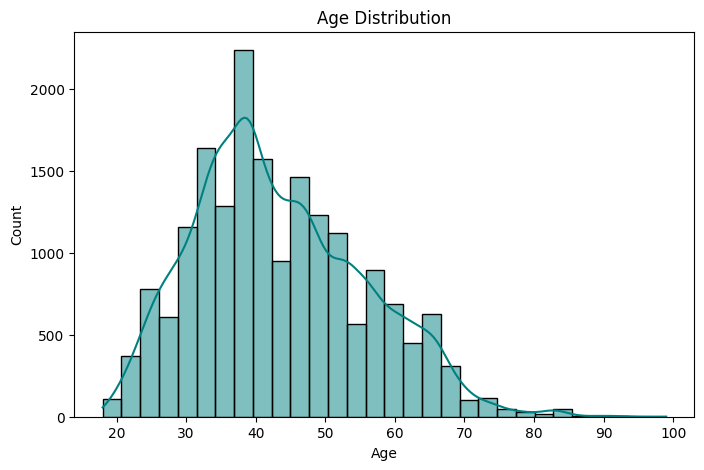

In [16]:
# Age Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], kde=True, bins=30, color='teal')
plt.title('Age Distribution')
plt.show()

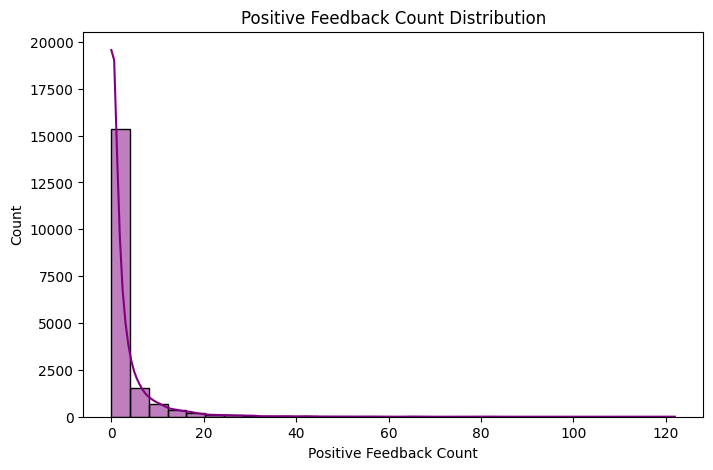

In [17]:
# Positive Feedback Count Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Positive Feedback Count'], kde=True, bins=30, color='purple')
plt.title('Positive Feedback Count Distribution')
plt.show()

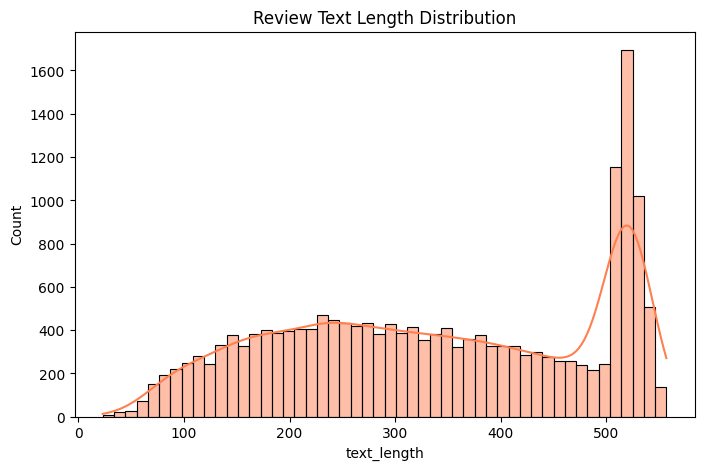

In [18]:
# Text Length (after merging title and review text)
df['full_text'] = (df['Title'].fillna('') + " " + df['Review Text'].fillna('')).str.strip()
df['text_length'] = df['full_text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True, color='coral')
plt.title('Review Text Length Distribution')
plt.show()

In [19]:
# Check missing values
print(df.isnull().sum())

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
full_text                  0
text_length                0
dtype: int64


# 3. Preparing Features & Target



## Preparing features (`X`) & target (`y`)

In [20]:
data = df

# separate features from labels
# Features and Target
X = df.drop(['Recommended IND'], axis=1)
y = df['Recommended IND'].copy()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=27, shuffle=True)


print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,full_text,text_length
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,524
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...",141
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,209
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,Not for the very petite I love tracy reese dre...,512
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,Cagrcoal shimmer fun I aded this in my basket ...,517


# Your Work

## Data Exploration

# 4. Preprocessing and Feature Engineering

In [21]:
# Custom Transformer: Combine Title + Review Text
def combine_text(data):
    return (data['Title'].fillna('') + " " + data['Review Text'].fillna('')).values

text_transformer = Pipeline(steps=[
    ('combine_text', FunctionTransformer(combine_text, validate=False)),
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'))
])

In [22]:
# Preprocessing for numeric features
numeric_features = ['Age', 'Positive Feedback Count']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [23]:
# Preprocessing for categorical features
categorical_features = ['Division Name', 'Department Name', 'Class Name', 'Clothing ID']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [24]:
# Full ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('txt', text_transformer, ['Title', 'Review Text'])
    ]
)

# 5. Building Pipelines

## Random Forest Pipeline

In [25]:
# Random Forest Classifier Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=27))
])

## Logistic Regression Pipeline

In [26]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


# 6. Model Experiments - Cross Validation

In [27]:
# Cross-Validation Score
rf_score = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()
logreg_score = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()

print(f'Random Forest CV Accuracy: {rf_score:.4f}')
print(f'Logistic Regression CV Accuracy: {logreg_score:.4f}')


Random Forest CV Accuracy: 0.8696
Logistic Regression CV Accuracy: 0.8965


## Training Pipeline

# 7. Fine-Tuning Random Forest

In [28]:
# Grid Search for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best parameters found:', grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


# 8. Final Model Evaluation

Test Accuracy: 0.8683
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.35      0.48       327
           1       0.87      0.98      0.92      1518

    accuracy                           0.87      1845
   macro avg       0.84      0.66      0.70      1845
weighted avg       0.86      0.87      0.85      1845



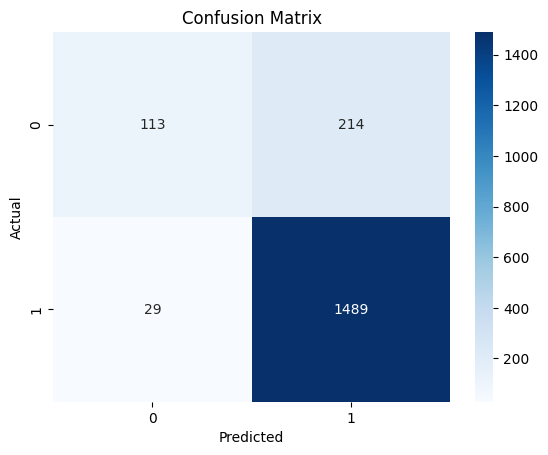

In [29]:
# Predict on test set
y_pred = grid_search.predict(X_test)

# Accuracy
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')

# Classification Report
print('Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()